In [1]:
from siphon.catalog import TDSCatalog
import xarray as xr
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Proj, transform

In [2]:
radar = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/nexrad/composite/unidata/latest.xml')
radar_ds = radar.datasets[0].remote_access(use_xarray=True)
radar_ds = radar_ds.metpy.parse_cf()

reflectivity = radar_ds['Base_reflectivity_surface_layer'].squeeze()
proj_info = radar_ds['LambertConformal_Projection']
plot_proj = reflectivity.metpy.cartopy_crs

In [11]:
ds = radar_ds.metpy.assign_crs(
    grid_mapping_name=proj_info.attrs['grid_mapping_name'],
    latitude_of_projection_origin=proj_info.attrs['latitude_of_projection_origin'],
    longitude_of_central_meridian=proj_info.attrs['longitude_of_central_meridian'],
    standard_parallel=proj_info.attrs['standard_parallel'],
    earth_radius=proj_info.attrs['earth_radius']
).metpy.assign_latitude_longitude()


point = ds['Base_reflectivity_surface_layer'].squeeze().metpy.sel(latitude=40.46, longitude=-75.32, method='nearest')
print(point)

ValueError: dimensions or multi-index levels ['latitude', 'longitude'] do not exist

In [12]:
print(ds)

<xarray.Dataset>
Dimensions:                          (time: 1, x: 4736, y: 3000)
Coordinates:
    reftime                          datetime64[ns] 2021-03-10T21:00:00
  * x                                (x) float32 -2.116e+06 ... 2.696e+06
  * y                                (y) float32 -1.679e+06 ... 1.369e+06
  * time                             (time) datetime64[ns] 2021-03-10T21:00:00
    metpy_crs                        object Projection: lambert_conformal_conic
    latitude                         (y, x) float64 23.0 23.0 ... 47.27 47.26
    longitude                        (y, x) float64 -120.0 -120.0 ... -63.57
Data variables:
    LambertConformal_Projection      >i4 0
    Base_reflectivity_surface_layer  (time, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     United States National Center for A...
    Originating_or_generating_Subcenter:  1
    GRIB_table_version:                   2,1
    Type_of_generating_process:           Missing
    file_format: 

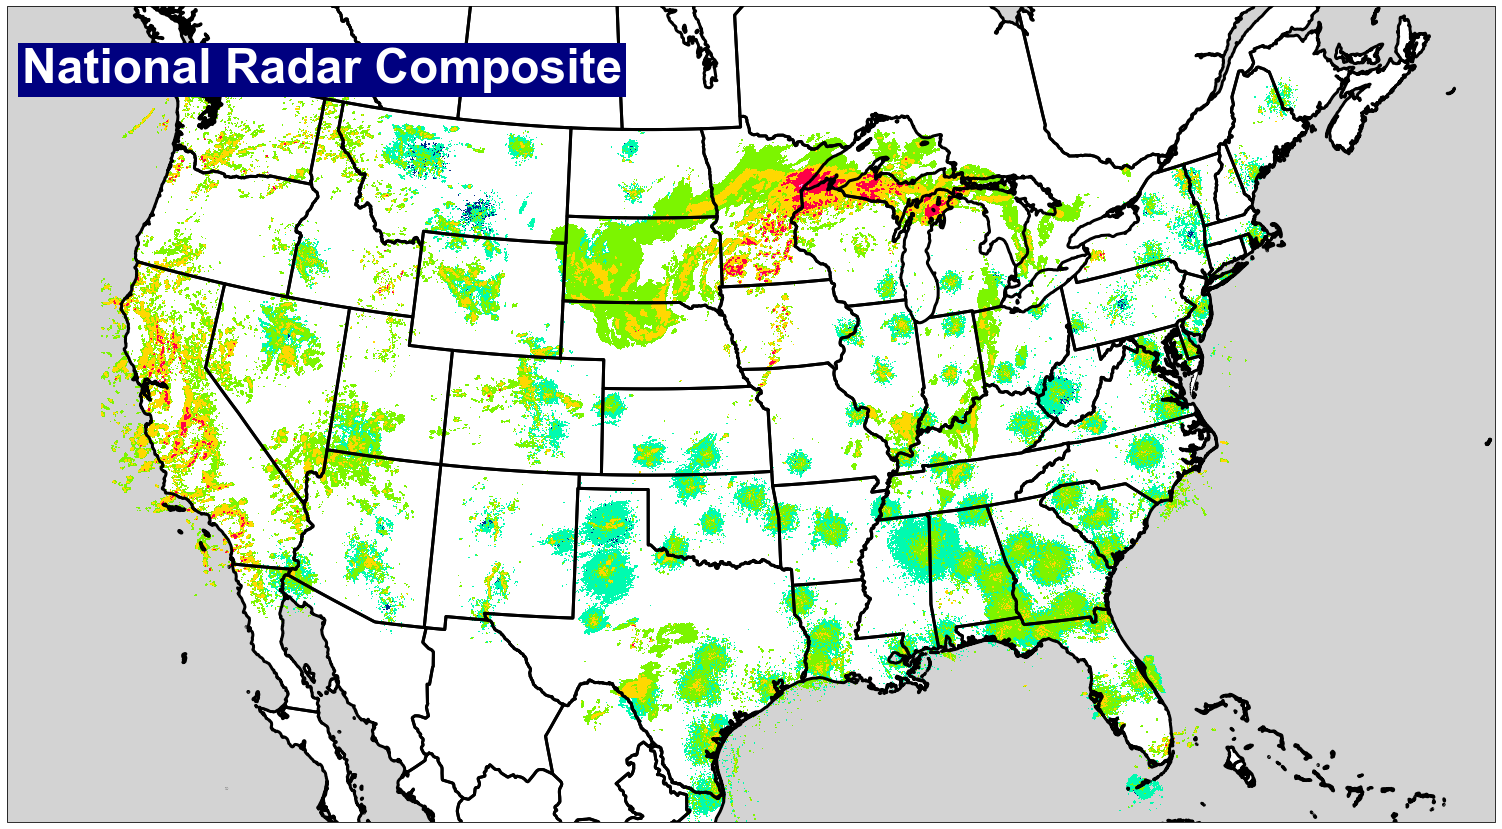

In [4]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_subplot(1, 1, 1, projection=plot_proj)
ax.set_extent((-122, -70, 25, 50), crs=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00)
ax.set_adjustable('datalim')

# Display Banner
plt.text(0.01, 0.95, s='National Radar Composite',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

ax.contourf(reflectivity.metpy.x, reflectivity.metpy.y, reflectivity,
            cmap=plt.cm.gist_ncar, transform=plot_proj)
